# CNN Classifier Training on NSL-KDD

This notebook trains a 1D Convolutional Neural Network for Network Intrusion Detection.

**Model:** CNNClassifier (PyTorch)  
**Dataset:** NSL-KDD  
**Task:** Binary Classification (Normal vs Attack)

## 1. Setup and Imports

In [55]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Memory: 6.4 GB


## 2. Load and Preprocess Data

In [56]:
# Column names for NSL-KDD
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load data
DATA_PATH = '../../data/raw/nsl-kdd/'
train_df = pd.read_csv(DATA_PATH + 'train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv(DATA_PATH + 'test.txt', header=None, names=COLUMNS)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Training samples: 125,973
Test samples: 22,544


In [57]:
# Binary labeling: Normal (0) vs Attack (1)
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print("Training distribution:")
print(train_df['binary_label'].value_counts())
print("\nTest distribution:")
print(test_df['binary_label'].value_counts())

Training distribution:
binary_label
0    67343
1    58630
Name: count, dtype: int64

Test distribution:
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [58]:
# Feature engineering
def preprocess_data(train_df, test_df):
    """
    Preprocess NSL-KDD data for CNN training.
    """
    # Identify categorical columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    
    # One-hot encode categorical features
    train_encoded = pd.get_dummies(train_df, columns=categorical_cols)
    test_encoded = pd.get_dummies(test_df, columns=categorical_cols)
    
    # Align columns (test may have different categories)
    train_cols = set(train_encoded.columns)
    test_cols = set(test_encoded.columns)
    
    # Add missing columns
    for col in train_cols - test_cols:
        if col not in ['label', 'difficulty_level', 'binary_label']:
            test_encoded[col] = 0
    for col in test_cols - train_cols:
        if col not in ['label', 'difficulty_level', 'binary_label']:
            train_encoded[col] = 0
    
    # Drop non-feature columns
    drop_cols = ['label', 'difficulty_level', 'binary_label']
    feature_cols = [c for c in train_encoded.columns if c not in drop_cols]
    feature_cols = sorted(feature_cols)  # Consistent ordering
    
    X_train = train_encoded[feature_cols].values
    X_test = test_encoded[feature_cols].values
    y_train = train_df['binary_label'].values
    y_test = test_df['binary_label'].values
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler, feature_cols

X_train, X_test, y_train, y_test, scaler, feature_cols = preprocess_data(train_df, test_df)

print(f"Features: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Features: 122
X_train shape: (125973, 122)
X_test shape: (22544, 122)


In [59]:
# Create validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)



print(f"Train: {X_train.shape[0]:,}")
print(f"Val: {X_val.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

Train: 100,778
Val: 25,195
Test: 22,544


In [60]:
# Create PyTorch DataLoaders
def create_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256):
    """
    Create PyTorch DataLoaders for training, validation, and testing.
    """
    # Reshape for CNN: (batch, channels, features)
    X_train_t = torch.FloatTensor(X_train).unsqueeze(1)
    X_val_t = torch.FloatTensor(X_val).unsqueeze(1)
    X_test_t = torch.FloatTensor(X_test).unsqueeze(1)
    
    y_train_t = torch.LongTensor(y_train)
    y_val_t = torch.LongTensor(y_val)
    y_test_t = torch.LongTensor(y_test)
    
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

BATCH_SIZE = 256
train_loader, val_loader, test_loader = create_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test, BATCH_SIZE
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 394
Val batches: 99
Test batches: 89


## 3. Define CNN Model

In [62]:
class CNNClassifier(nn.Module):
    """
    1D Convolutional Neural Network for NIDS classification.
    Uses AdaptiveAvgPool to handle variable input dimensions.
    """
    def __init__(self, input_dim, num_classes=2, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        
        # Conv Block 1
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        # Conv Block 2
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        # Conv Block 3
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        # Adaptive pooling to fixed size (works with any input dim)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(8)
        
        # Fully connected layers (256 channels * 8 from adaptive pool)
        self.fc1 = nn.Linear(256 * 8, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Conv layers
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        # Adaptive pooling to fixed size
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create model
input_dim = X_train.shape[1]
print(f'Input dimension: {input_dim}')
model = CNNClassifier(input_dim=input_dim, num_classes=2, dropout_rate=0.3)
model = model.to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Input dimension: 122
CNNClassifier(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=8)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

Total parameters: 665,538
Trainable parameters: 665,538


## 4. Training Configuration

In [63]:
# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10

# Loss and optimizer
# Calculate class weights to handle imbalance
# Count: Normal = 53874, Attack = 46904 (in training set)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class_weights = torch.tensor([0.7, 1.5]).to(device)  # Higher weight for Attack class
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

Epochs: 50
Learning Rate: 0.001
Batch Size: 256
Early Stopping Patience: 10


## 5. Training Loop

In [64]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / total, correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    return total_loss / total, correct / total

In [65]:
# Training
print("Starting Training...")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
best_model_state = None
patience_counter = 0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        save_marker = "*"
    else:
        patience_counter += 1
        save_marker = ""
    
    # Print progress
    print(f"Epoch {epoch:3d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} {save_marker}")
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}")
        break

# Restore best model
model.load_state_dict(best_model_state)

training_time = time.time() - start_time
print(f"\nTraining complete! Time: {training_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Starting Training...
Epoch   1/50 | Train Loss: 0.0226 | Train Acc: 0.9694 | Val Loss: 0.0137 | Val Acc: 0.9813 *
Epoch   2/50 | Train Loss: 0.0111 | Train Acc: 0.9850 | Val Loss: 0.0095 | Val Acc: 0.9880 *
Epoch   3/50 | Train Loss: 0.0093 | Train Acc: 0.9875 | Val Loss: 0.0087 | Val Acc: 0.9905 *
Epoch   4/50 | Train Loss: 0.0084 | Train Acc: 0.9889 | Val Loss: 0.0083 | Val Acc: 0.9906 *
Epoch   5/50 | Train Loss: 0.0073 | Train Acc: 0.9903 | Val Loss: 0.0071 | Val Acc: 0.9902 
Epoch   6/50 | Train Loss: 0.0068 | Train Acc: 0.9911 | Val Loss: 0.0071 | Val Acc: 0.9914 *
Epoch   7/50 | Train Loss: 0.0067 | Train Acc: 0.9914 | Val Loss: 0.0073 | Val Acc: 0.9906 
Epoch   8/50 | Train Loss: 0.0063 | Train Acc: 0.9916 | Val Loss: 0.0067 | Val Acc: 0.9910 
Epoch   9/50 | Train Loss: 0.0064 | Train Acc: 0.9916 | Val Loss: 0.0051 | Val Acc: 0.9928 *
Epoch  10/50 | Train Loss: 0.0058 | Train Acc: 0.9921 | Val Loss: 0.0066 | Val Acc: 0.9911 
Epoch  11/50 | Train Loss: 0.0054 | Train Acc: 0.9930

## 6. Training Visualization

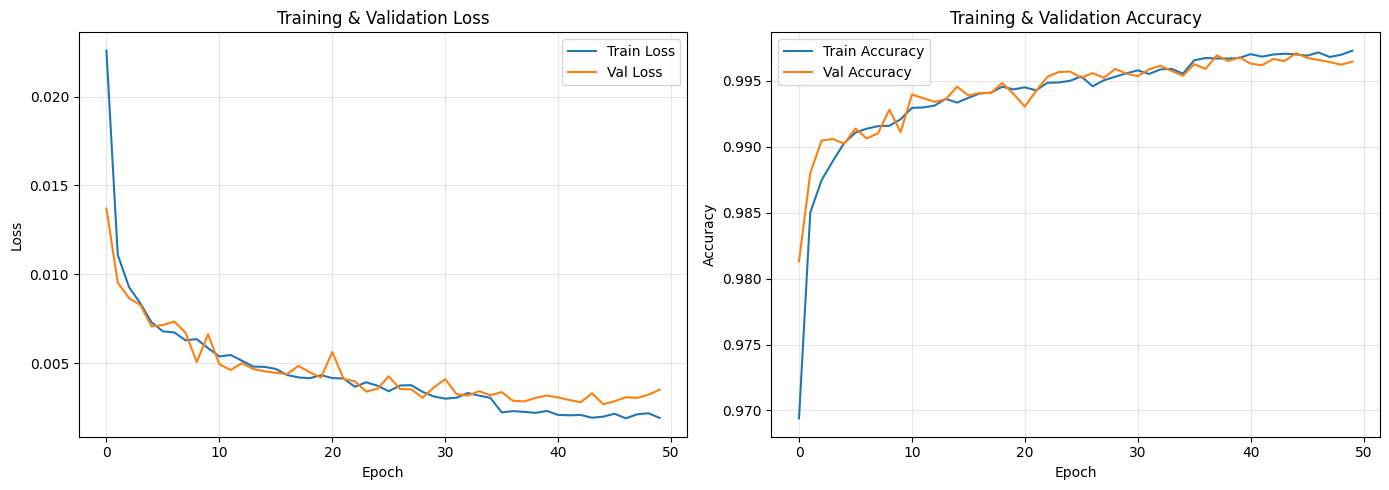

Training plot saved!


In [66]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/cnn_training_history.png', dpi=150)
plt.show()

print("Training plot saved!")

## 7. Model Evaluation

In [67]:
def evaluate_model(model, test_loader, device):
    """
    Full evaluation on test set.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            predicted = (probs[:, 1] > 0.35).long()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

y_pred, y_true, y_probs = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

TEST SET RESULTS
Accuracy:  0.8135
Precision: 0.9633
Recall:    0.6991
F1-Score:  0.8102


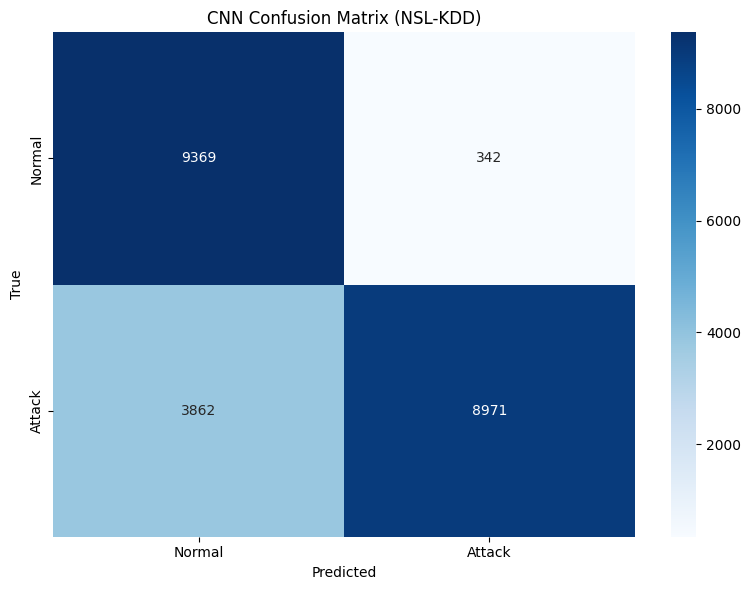


Classification Report:
              precision    recall  f1-score   support

      Normal       0.71      0.96      0.82      9711
      Attack       0.96      0.70      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



In [68]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix (NSL-KDD)')
plt.tight_layout()
plt.savefig('../../results/figures/cnn_confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

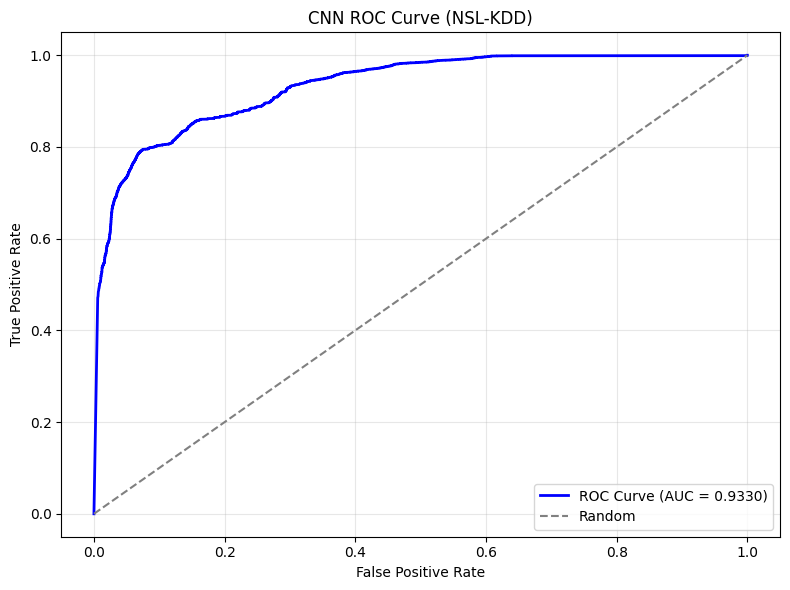

ROC-AUC Score: 0.9330


In [69]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve (NSL-KDD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/figures/cnn_roc_curve.png', dpi=150)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

## 8. Save Model

In [71]:
import os
import pickle

# Create models directory
os.makedirs('../../results/models', exist_ok=True)

# Save model
model_path = '../../results/models/cnn_nsl_kdd.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'num_classes': 2,
    'training_history': history,
    'best_val_acc': best_val_acc,
    'test_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
}, model_path)

print(f"Model saved to: {model_path}")

# Save scaler
scaler_path = '../../results/models/cnn_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to: {scaler_path}")

Model saved to: ../../results/models/cnn_nsl_kdd.pt
Scaler saved to: ../../results/models/cnn_scaler.pkl


## 9. Summary

In [72]:
print("\n" + "=" * 60)
print("CNN TRAINING SUMMARY")
print("=" * 60)
print(f"Model: 1D CNN Classifier")
print(f"Dataset: NSL-KDD")
print(f"Task: Binary Classification (Normal vs Attack)")
print(f"\nTraining:")
print(f"  - Epochs: {len(history['train_loss'])}")
print(f"  - Training Time: {training_time/60:.1f} minutes")
print(f"  - Best Val Accuracy: {best_val_acc:.4f}")
print(f"\nTest Results:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-Score:  {f1:.4f}")
print(f"  - ROC-AUC:   {roc_auc:.4f}")
print("=" * 60)

torch.cuda.empty_cache()
import gc
gc.collect()


CNN TRAINING SUMMARY
Model: 1D CNN Classifier
Dataset: NSL-KDD
Task: Binary Classification (Normal vs Attack)

Training:
  - Epochs: 50
  - Training Time: 4.0 minutes
  - Best Val Accuracy: 0.9971

Test Results:
  - Accuracy:  0.8135
  - Precision: 0.9633
  - Recall:    0.6991
  - F1-Score:  0.8102
  - ROC-AUC:   0.9330


10794